In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

import time
import pickle

from qiskit import transpile
from qiskit.quantum_info import Operator

from topology import *

from jax import custom_jvp, jvp, grad
from jax.scipy.optimize import minimize

key = random.PRNGKey(42)

# Random losses

In [4]:
def int_to_list(n, size):
    """Examples:
        (10, 5) -> [0, 1, 0, 1, 0]
        (11, 6) -> [0, 0, 1, 0, 1, 0]
        (11, 6) -> [0, 0, 1, 0, 1, 1] """
    n_str = format(n, 'b')
    assert len(n_str)<=size, 'Integer {} too big to be converted to size {}'.format(n, size)
    
    zero_pad = '0'*(size-len(n_str))
    n_str = zero_pad + n_str
    
    return [int(b) for b in n_str]

def all_binary_strings(size):
    """Example, size=3:
        [[0, 0, 0],
         [0, 0, 1],
         [0, 1, 0],
         [0, 1, 1],
         [1, 0, 0],
         [1, 0, 1],
         [1, 1, 0],
         [1, 1, 1]]
    """
    
    max_n = int('1'*size, 2)+1
    return [int_to_list(n, size) for n in range(max_n)]

def cos_sin_monomials(angles, n_angles):
    """Example angles=(a0, a1) n_angles=2:
    [cos a0/2 cos a1/2,
     cos a0/2 sin a1/2,
     sin a0/2 cos a1/2,
     sin a0/2 sin a1/2]
    """
    powers = 1-jnp.array(all_binary_strings(int(n_angles)))
    cos_sin_array = jnp.cos(angles/2)**powers * jnp.sin(angles/2)**(1-powers)
    cos_sin_monomials = jnp.prod(cos_sin_array, axis=1)
    return cos_sin_monomials

def trigonometric_sum_func(coeffs, n_angles):
    """Example coefss=[1,2,3,4], n_angles=2:
        1*cos a0/2 cos a1/2+2*cos a0/2 sin a1/2+3*sin a0/2 cos a1/2+4*sin a0/2 sin a1/2"""
    return lambda angles: jnp.tensordot(cos_sin_monomials(angles, n_angles), coeffs, axes=1)

def trigonometric_coefficients(f, n_angles):
    """Example n_angles=2: 
        1*cos a0/2 cos a1/2+2*cos a0/2 sin a1/2+3*sin a0/2 cos a1/2+4*sin a0/2 sin a1/2 -> [1,2,3,4]"""
    all_vertices = jnp.pi*jnp.array(all_binary_strings(int(n_angles)))
    return vmap(f)(all_vertices)

Illustration.

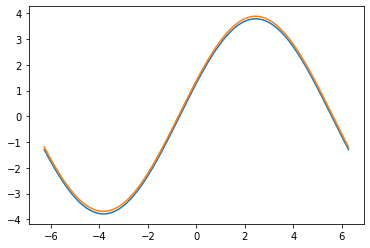

In [5]:
coeffs0=jnp.array([1, 2, 3, 4], dtype='float32') # Define coefficients
n_angles0 = int(jnp.log2(len(coeffs0))) # Number of angles is log 2 of number of coefficients.

f0 = trigonometric_sum_func(coeffs0, n_angles0) # Define function with precsribed coefficients

# Choose random y and sweep over x to compare explicit funciton and the one defined implicitly.
x_sweep = jnp.linspace(-2*jnp.pi, 2*jnp.pi, 1000)
y = 0.3

plt.plot(x_sweep, vmap(lambda x: f0(jnp.array([x, y], dtype='float32')))(x_sweep))
plt.plot(x_sweep, jnp.cos(x_sweep/2)*jnp.cos(y/2)+
         2*jnp.cos(x_sweep/2)*jnp.sin(y/2)+
         3*jnp.sin(x_sweep/2)*jnp.cos(y/2)+
         4*jnp.sin(x_sweep/2)*jnp.sin(y/2)+0.1) # SHift added for clarity.

Now let us see whether local minima are problematic for random trigonometric sums.

In [4]:
def random_trigonometric_loss(num_angles, key=random.PRNGKey(0)):
    key, subkey = random.split(key)
    unbalanced_coeffs = random.uniform(subkey, shape=(2, 2**num_angles, ), minval=0, maxval=1)
    unbalanced_coeffs = unbalanced_coeffs[0]+1j*unbalanced_coeffs[1]
    unbalanced_f = trigonometric_sum_func(unbalanced_coeffs, num_angles)
    
    key, subkey = random.split(key)
    min_angles = random_angles(num_angles, key=subkey)
    
    c0 =unbalanced_coeffs[0] - unbalanced_f(min_angles)/cos_sin_monomials(min_angles, num_angles)[0]
    balanced_coeffs = unbalanced_coeffs.at[0].set(c0)
    
    balanced_f = trigonometric_sum_func(balanced_coeffs, num_angles)
    
    return lambda angles: jnp.abs(balanced_f(angles))**2

In [5]:
%%time
num_angles = 14
loss_func = random_trigonometric_loss(num_angles, key=random.PRNGKey(5))
ah, lh = optax_minimize(loss_func, num_angles, optax.adam(0.1))

CPU times: user 45.6 s, sys: 391 ms, total: 46 s
Wall time: 26.5 s


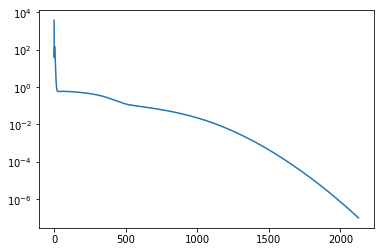

In [6]:
plt.plot(lh)
plt.yscale('log')

It appears that under 15 or so angles the local minumums are not problematic for random trigonometric functions. Going above 15 angles seems to be too expensive. However, in the next section we will find realistic examples that have local minumums and not too much parameters.

# Unitary losses

It seems that good examples of local minimum problem can be found if we take a circuit with many cnot but fix some of the angles (to bring the number of parameters down). Here is an example.

In [2]:
def insert_angles(angles, insertion_angles, indices):
    """Replaces angles at positions specified by indices by insertion angles."""
    new_angles = angles
    for a, i in zip(insertion_angles, indices):
        new_angles = new_angles.at[i].set(a)
    return new_angles

def u_func_constrained(u_func, target_angles, indices):
    """Returns a function with angles=target_angles EXCEPT at positions specified by indices. There the angles are free parameters."""
    return lambda free_angles: u_func(insert_angles(target_angles, free_angles, indices))

Initial angles in the definition of the target can be changed with the local minimum problem being fairly robust. This way one can obtain a series of examples to test against optimization ideas.

In [17]:
%%time

anz = Ansatz(3, 'cz', fill_layers(sequ_layer(3), 4))

angles_target = random_angles(anz.num_angles, key=random.PRNGKey(1000))
u_target = anz.unitary(angles_target)

num_free_angles = 13
indices = jnp.sort(random.choice(random.PRNGKey(100), jnp.arange(anz.num_angles), shape=(num_free_angles, ), replace=False))
constrained_u = u_func_constrained(anz.unitary, angles_target, indices)
free_angles_target = jnp.array([angles_target[i] for i in indices])

ah, lh, sh = unitary_learn_repeat(constrained_u, 
                                  u_target, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1, 
                                  num_repeats=10, 
                                  target_loss=1e-4)

CPU times: user 1min 38s, sys: 2.67 s, total: 1min 41s
Wall time: 1min 33s


In [18]:
sum(sh)/len(sh)

0.1

# Ancilla qubits

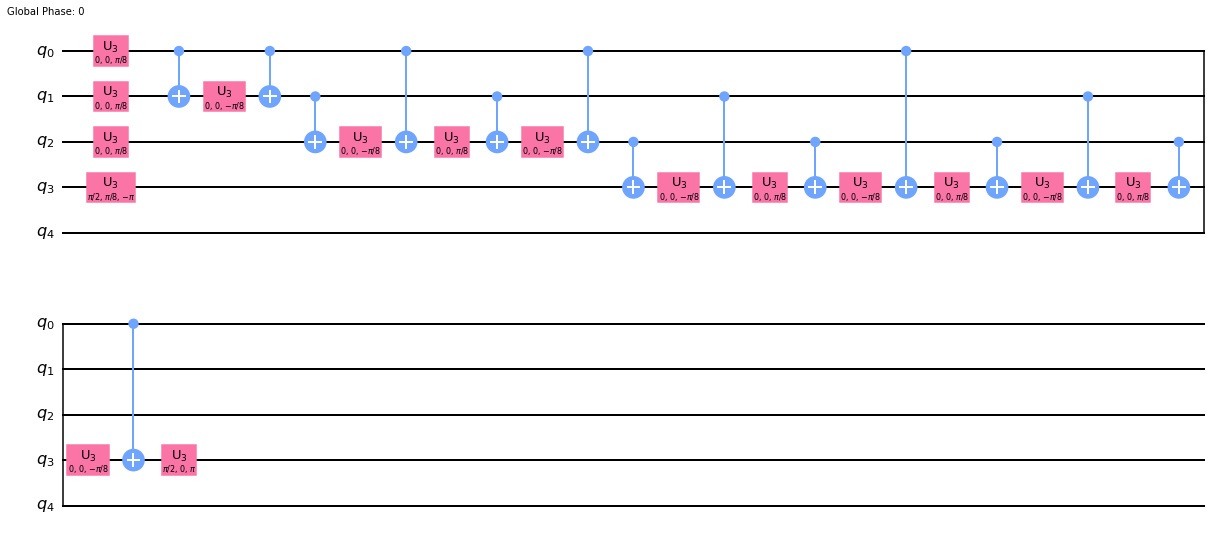

In [14]:
qc = QuantumCircuit(5)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data

qc.draw(output='mpl')
transpile(qc, basis_gates=['u3', 'cx'], optimization_level=3).draw(output='mpl')

In [22]:
%%time

anz = Ansatz(5, 'cz', fill_layers(chain_layer(5), 27))

ah, lh, sh = unitary_learn_repeat(anz.unitary, 
                                  u_toff4, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1, 
                                  num_repeats=20, 
                                  target_loss=1e-4)

print(sum(sh)/len(sh))

0.0
CPU times: user 6min 24s, sys: 6.42 s, total: 6min 31s
Wall time: 5min 38s


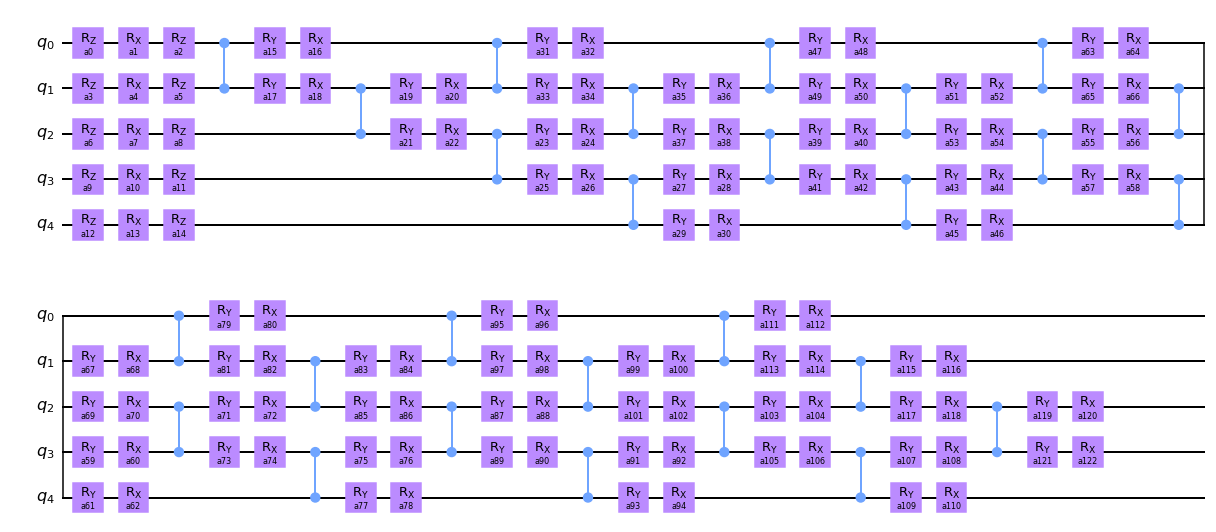

In [23]:
anz.circuit().draw(output='mpl')

# Redundant 1q gates.

In [10]:
anz = Ansatz(3, 'cz', fill_layers(sequ_layer(3), 6))

angles_target = random_angles(anz.num_angles, key=random.PRNGKey(1000))
u_target = anz.unitary(angles_target)


repeated_layer = [sequ_layer(3)[i//3] for i in range(3*len(sequ_layer(3)))]
anz_cp = Ansatz(3, 'cp', fill_layers(repeated_layer, 4*3))

cp_mask = jnp.array(anz_cp.cp_mask)
mask_indices = jnp.nonzero(cp_mask)[0]
mask_angles = jnp.pi*jnp.array([1 if i%3==0 else 0 for i in range(len(mask_indices))])

zero_angles_with_mask_fixed = insert_angles(jnp.zeros(anz_cp.num_angles), mask_angles, mask_indices)
free_angles_indices = [i for i in range(anz_cp.num_angles) if i not in mask_indices]
num_free_angles = len(free_angles_indices)

anz_cp.circuit(zero_angles_with_mask_fixed).draw()
u_cp_constrainded = u_func_constrained(anz_cp.unitary, zero_angles_with_mask_fixed, free_angles_indices)

In [11]:
%%time

ah, lh, sh = unitary_learn_repeat(anz.unitary, 
                                  u_target, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1, 
                                  num_repeats=10, 
                                  target_loss=1e-4)

sum(sh)/len(sh)

CPU times: user 1min 39s, sys: 3.02 s, total: 1min 42s
Wall time: 1min 33s


0.1

In [12]:
%%time
ah, lh, sh = unitary_learn_repeat(u_cp_constrainded, 
                                  u_target, 
                                  num_free_angles, 
                                  'adam', 
                                  0.1, 
                                  num_repeats=10, 
                                  target_loss=1e-4)

sum(sh)/len(sh)

CPU times: user 5min 27s, sys: 3.69 s, total: 5min 31s
Wall time: 5min 20s


0.0

# Fourier-Poisson optimization

In [121]:
def exact_average(F, n_angles):
    
    grid_points = 2*jnp.pi*jnp.array(all_binary_strings(n_angles))
    F_grid = vmap(F)(grid_points)
    
    return F_grid.sum()/len(grid_points)

In [15]:
%%time

anz = Ansatz(3, 'cz', fill_layers(sequ_layer(3), 4))

angles_target = random_angles(anz.num_angles, key=random.PRNGKey(1000))
u_target = anz.unitary(angles_target)

num_free_angles = 13
indices = jnp.sort(random.choice(random.PRNGKey(100), jnp.arange(anz.num_angles), shape=(num_free_angles, ), replace=False))
constrained_u = u_func_constrained(anz.unitary, angles_target, indices)
free_angles_target = jnp.array([angles_target[i] for i in indices])

real_cost = lambda angs: 8-jnp.real((constrained_u(angs)*u_target.conj()).sum())

initial_angles = random_angles(num_free_angles, key=random.PRNGKey(8))
ah, lh = optax_minimize(real_cost, 
                        num_free_angles, 
                        optax.adam(0.1), 
                        preconditioner_func=plain_natural_preconditioner(constrained_u),
                        initial_params=initial_angles,
                        target_loss=1e-4)

CPU times: user 25.7 s, sys: 10.1 s, total: 35.8 s
Wall time: 17.2 s


In [68]:
def exp_loss(lmbd, angles):
    return -jnp.exp(-lmbd*real_cost(angles))

@jit
def exp_loss_norm(lmbd, angles):
    return exp_loss(lmbd, angles) - exact_average(lambda angs: exp_loss(lmbd, angs), num_free_angles)

In [109]:
print(real_cost(free_angles_target))
print(real_cost(free_angles_target+4*jnp.pi*jnp.zeros(num_free_angles).at[0].set(1)))

4.7683716e-07
4.7683716e-07


In [128]:
def abavg(lmbd, a):
    return exact_average(lambda angs: exp_loss(lmbd, jnp.concatenate([jnp.array([a]), angs])), num_free_angles-1)

In [129]:
lmbd=1
print(abavg(lmbd, 0))
print(abavg(lmbd, 1*jnp.pi))

-0.00038929778
-0.00034686172


In [130]:
free_angles_target

DeviceArray([1.4085239 , 0.5855335 , 0.81626433, 0.95043296, 4.157632  ,
             3.6373787 , 3.186574  , 2.2470086 , 1.1132274 , 5.635514  ,
             1.4421338 , 3.1975808 , 2.3271897 ], dtype=float32)

In [96]:
exact_average(lambda angs: exp_loss(1, angs), num_free_angles)

DeviceArray(-0.00030679, dtype=float32)

In [99]:
lmbd = 1
a = exact_average(lambda angs: exp_loss_norm(lmbd, jnp.concatenate([jnp.array([0]), angs])), num_free_angles-1)
b = exact_average(lambda angs: exp_loss_norm(lmbd, jnp.concatenate([jnp.array([jnp.pi]), angs])), num_free_angles-1)

In [100]:
a, b

(DeviceArray(2.175722e-05, dtype=float32),
 DeviceArray(-0.00016833, dtype=float32))

In [80]:
exp_loss_norm(1, free_angles_target)

DeviceArray(-0.9995692, dtype=float32)

In [94]:
exp_loss(1, free_angles_target+2.3*jnp.pi*jnp.concatenate([jnp.array([1]), jnp.zeros(num_free_angles-1)]))

DeviceArray(-2.69135e-07, dtype=float32)

# Real part optimization.

In [93]:
%%time

anz = Ansatz(3, 'cz', fill_layers(sequ_layer(3), 4))

angles_target = random_angles(anz.num_angles, key=random.PRNGKey(1000))
u_target = anz.unitary(angles_target)

num_free_angles = 13
indices = jnp.sort(random.choice(random.PRNGKey(100), jnp.arange(anz.num_angles), shape=(num_free_angles, ), replace=False))
constrained_u = u_func_constrained(anz.unitary, angles_target, indices)
free_angles_target = jnp.array([angles_target[i] for i in indices])

real_cost = lambda angs: 8-jnp.real((constrained_u(angs)*u_target.conj()).sum())

initial_angles = random_angles(num_free_angles, key=random.PRNGKey(8))
ah, lh = optax_minimize(real_cost, 
                        num_free_angles, 
                        optax.adam(0.1), 
                        preconditioner_func=plain_natural_preconditioner(constrained_u),
                        initial_params=initial_angles,
                        target_loss=1e-4)

CPU times: user 27.9 s, sys: 11.8 s, total: 39.8 s
Wall time: 19.2 s


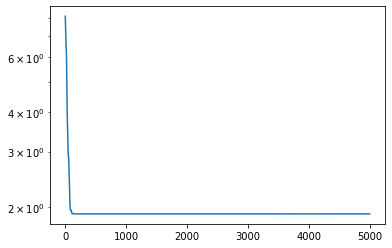

In [94]:
plt.plot(lh)
plt.yscale('log')

# SGD optimization

In [6]:
anz = Ansatz(3, 'cz', fill_layers(sequ_layer(3), 4))

angles_target = random_angles(anz.num_angles, key=random.PRNGKey(1004))
u_target = anz.unitary(angles_target)

num_free_angles = 13
indices = jnp.sort(random.choice(random.PRNGKey(100), jnp.arange(anz.num_angles), shape=(num_free_angles, ), replace=False))
constrained_u = u_func_constrained(anz.unitary, angles_target, indices)
free_angles_target = jnp.array([angles_target[i] for i in indices])

def frobenius_loss(angles, minibatch):
    u_diff = jnp.abs(constrained_u(angles)-u_target)**2
    u_diff = u_diff.reshape(-1)
    
    return (u_diff*minibatch).sum()

In [63]:
%%time


@partial(jit, static_argnums=(0, 1))
def batch_update_step(loss_and_grad, opt, opt_state, params, minibatch):

    loss, grads = loss_and_grad(params, minibatch)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


num_iterations = 5000
minibatch_size = 16
opt = optax.adam(0.1)
initial_angles = random_angles(num_free_angles, key=random.PRNGKey(6))
# initial_angles = free_angles_target+0.1
opt_state = opt.init(initial_angles)
num_matrix_entries = len(u_target.reshape(-1))

loss_and_grad = value_and_grad(frobenius_loss, argnums=0)

angles = initial_angles
angles_history = []
loss_history = []
for i in range(num_iterations):
    key, subkey = random.split(key)
    
    minibatch = jnp.sort(random.choice(subkey, jnp.arange(num_matrix_entries), (minibatch_size, ), replace=False))
    minibatch = jnp.array([1 if i in minibatch else 0 for i in range(num_matrix_entries)])
    ## !!Warining! overriding sensible behaviour!!
    minibatch = jnp.array([1 if i<5 else 0 for i in range(num_matrix_entries)])
    minibatch = random.shuffle(random.PRNGKey(1), minibatch)
    
    angles, opt_state, loss = batch_update_step(loss_and_grad, opt, opt_state, angles, minibatch)
    angles_history.append(angles)
    loss_history.append(loss)
    
full_loss_history = vmap(jit(lambda angs: frobenius_loss(angs, jnp.ones(num_matrix_entries))))(jnp.array(angles_history))

/home/idnm/.local/lib/python3.8/site-packages/jax/_src/random.py:517: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation
  warnings.warn(msg, FutureWarning)


CPU times: user 35.6 s, sys: 1.35 s, total: 36.9 s
Wall time: 32.5 s


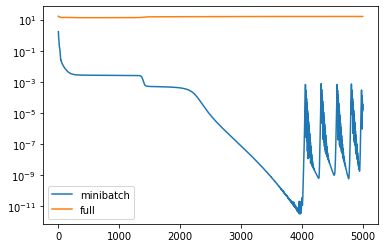

In [62]:
plt.plot(loss_history, label='minibatch')
plt.plot(full_loss_history, label='full')
plt.legend()
plt.yscale('log')

# Weighted Frobenius optimization.

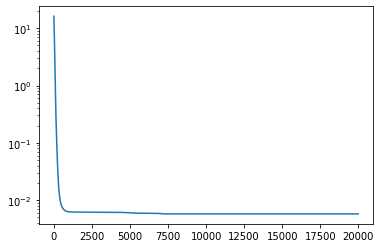

In [76]:
num_qubits = 3
anz = Ansatz(num_qubits, 'cz', fill_layers(sequ_layer(num_qubits), 4))

angles_target = random_angles(anz.num_angles, key=random.PRNGKey(1004))
u_target = anz.unitary(angles_target)

num_free_angles = 13
indices = jnp.sort(random.choice(random.PRNGKey(100), jnp.arange(anz.num_angles), shape=(num_free_angles, ), replace=False))
free_angles_target = jnp.array([angles_target[i] for i in indices])

constrained_u = u_func_constrained(anz.unitary, angles_target, indices)

r = 0.0001

def multi_loss(params):
    angles = params[:num_free_angles]
    lambdas = params[num_free_angles:4**num_qubits+num_free_angles]
    u_diff=constrained_u(angles)-u_target
    u_diff = u_diff.reshape(-1)
    
    return jnp.real(((lambdas)**2 * u_diff * u_diff.conj()+r*(1-lambdas)**2).sum())

initial_angles = random_angles(num_free_angles, key=random.PRNGKey(2))

initial_lambdas = jnp.ones((4**num_qubits, ))
initial_params = jnp.concatenate([initial_angles, initial_lambdas])

ah, lh = optax_minimize(multi_loss, num_free_angles+4**num_qubits, optax.adam(0.01), initial_params=initial_params, num_iterations=20000)
plt.plot(lh)
plt.yscale('log')

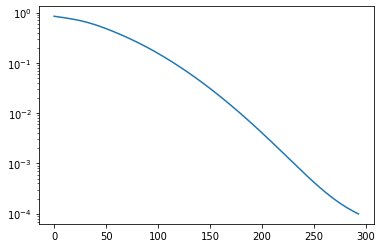

In [77]:
ah1, lh1 = unitary_learn(constrained_u, 
                                  u_target, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.01, 
                                  initial_params=ah[-1][:num_free_angles],
                                  target_loss=1e-4)

plt.plot(lh1)
plt.yscale('log')

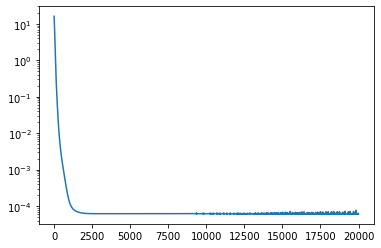

In [96]:
num_qubits = 3
anz = Ansatz(num_qubits, 'cz', fill_layers(sequ_layer(num_qubits), 4))

angles_target = random_angles(anz.num_angles, key=random.PRNGKey(1004))
u_target = anz.unitary(angles_target)

num_free_angles = 13
indices = jnp.sort(random.choice(random.PRNGKey(100), jnp.arange(anz.num_angles), shape=(num_free_angles, ), replace=False))
free_angles_target = jnp.array([angles_target[i] for i in indices])

constrained_u = u_func_constrained(anz.unitary, angles_target, indices)

r = 0.000001

def multi_loss(params):
    angles = params[:num_free_angles]
    lambdas = params[num_free_angles:4**num_qubits+num_free_angles]
    u_diff=constrained_u(angles)-u_target
    u_diff = u_diff.reshape(-1)
    
    return jnp.real(((lambdas)**2 * u_diff * u_diff.conj()+r*(1-lambdas)**2).sum())

initial_angles = random_angles(num_free_angles, key=random.PRNGKey(2))

initial_lambdas = jnp.ones((4**num_qubits, ))
initial_params = jnp.concatenate([initial_angles, initial_lambdas])

ah, lh = optax_minimize(multi_loss, num_free_angles+4**num_qubits, optax.adam(0.01), initial_params=initial_params, num_iterations=20000)
plt.plot(lh)
plt.yscale('log')

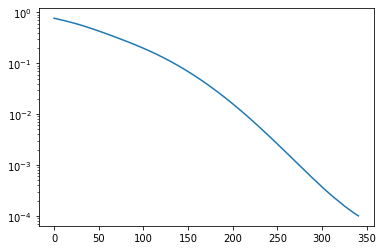

In [97]:
ah1, lh1 = unitary_learn(constrained_u, 
                                  u_target, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.01, 
                                  initial_params=ah[-1][:num_free_angles],
                                  target_loss=1e-4)

plt.plot(lh1)
plt.yscale('log')

# Poisson optimization

In [45]:
anz = Ansatz(3, 'cz', fill_layers(sequ_layer(3), 4))

angles_target = random_angles(anz.num_angles, key=random.PRNGKey(1006))
u_target = anz.unitary(angles_target)
pre_loss = lambda angles: trace_prod(u_target, anz.unitary(angles))

num_free_angles = 13
indices = jnp.sort(random.choice(random.PRNGKey(100), jnp.arange(anz.num_angles), shape=(num_free_angles, ), replace=False))

constrained_u = u_func_constrained(anz.unitary, angles_target, indices)
constrained_pre_loss = u_func_constrained(pre_loss, angles_target, indices)

In [46]:
# Check that pre_loss reproduces our loss
free_angles_sample = random_angles(num_free_angles)

print(disc2(u_target, constrained_u(free_angles_sample)))
print(1 - jnp.abs(constrained_pre_loss(free_angles_sample)) ** 2 / 8 ** 2)

0.9994712
0.9994712


In [47]:
coeffs_array = trigonometric_coefficients(constrained_pre_loss, num_free_angles).reshape([2]*num_free_angles)
def ABcoeffs(coeffs_array, i):
    W0 = jnp.take(coeffs_array, indices=0, axis=i)
    W1 = jnp.take(coeffs_array, indices=1, axis=i)
    A = -(W0*W0.conj()-W1*W1.conj()).sum()/2
    B = -(W0*W1.conj()).sum()
    return jnp.real(A), jnp.real(B)

def AB_angle(A, B):
    AB_func = lambda x: A*jnp.cos(x)+B*jnp.sin(x)
    return min_angle(AB_func)

guess_angles = jnp.array([AB_angle(*ABcoeffs(coeffs_array, i)) for i in range(num_free_angles)])

In [48]:
ah, lh, sh = unitary_learn_repeat(constrained_u, 
                                  u_target, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1, 
                                  num_repeats=10, 
                                  target_loss=1e-4)

print(sum(sh)/len(sh))

0.0


In [49]:
ah, lh = unitary_learn(constrained_u, 
                                  u_target, 
                                  anz.num_angles, 
                                  'natural adam', 
                                  0.1, 
                                  initial_params=guess_angles,
                                  target_loss=1e-4)


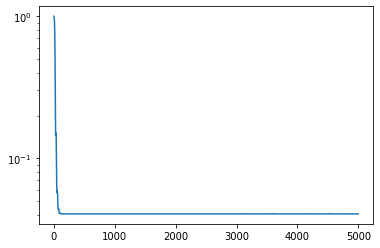

In [50]:
plt.plot(lh)
plt.yscale('log')